<a href="https://colab.research.google.com/github/sivaa-shaanth/cs469-recommender-model/blob/main/Recommender_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import torch
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from numpy import inf



In [2]:
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve ("https://github.com/aravindsankar28/Recommender-Models/blob/main/ml-100k.zip?raw=true", "ml-100k.zip")
zip_ref = zipfile.ZipFile('ml-100k.zip', "r")

zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))



Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


We first load the MovieLens Data, and create DataFrames containing movies, users, and ratings.


In [3]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')


In [4]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')


In [5]:
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [6]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))


In [7]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens = movielens.drop(columns = ["video_release_date", "imdb_url"])

In [8]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,genre_unknown,Action,Adventure,Animation,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,0,0,0,0,...,0,0,0,0,0,1997,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,0,1,1,0,...,0,1,0,0,0,1997,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,0,0,0,0,...,1,0,0,0,0,1996,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,0,0,0,0,...,0,0,0,0,0,1996,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,0,0,0,0,...,0,0,0,0,0,1994,49,M,writer,55105


In [9]:
def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.flatten_cols = flatten_cols

users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

users_ratings.head()


,user_id,rating count,rating mean,age,sex,occupation,zip_code
0,0,272,3.610294,24,M,technician,85711
1,1,62,3.709677,53,F,other,94043
2,2,54,2.796296,23,M,writer,32067
3,3,24,4.333333,24,M,technician,43537
4,4,175,2.874286,33,F,other,15213


### Question 1: Rating Distribution of users.
First, we look at the distribution of ratings per user to examine number of ratings and average rating per user.

Plot two histograms depicting: (a) the number of ratings per user and (b) average rating per user. (Use plt.hist with 10 bins)

What do you observe?



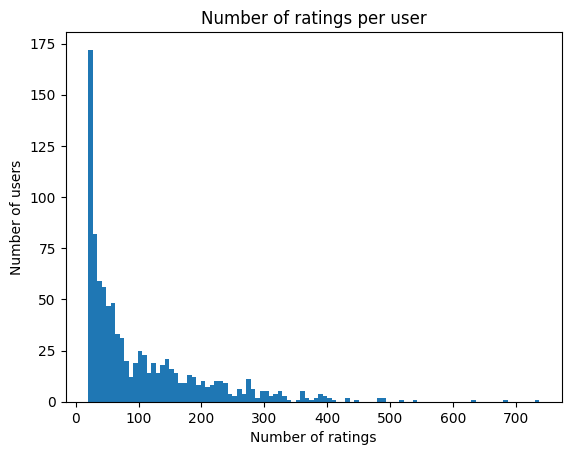

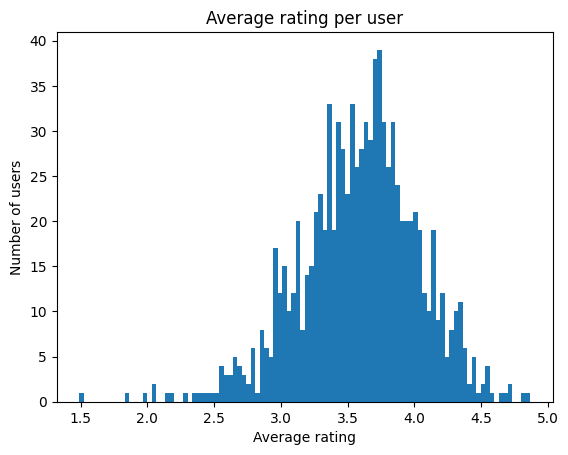

In [10]:
#plot the number of ratings per user
plt.hist(users_ratings['rating count'], bins=100)
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.title('Number of ratings per user')
plt.show()

#plot the average rating per user
plt.hist(users_ratings['rating mean'], bins=100)
plt.xlabel('Average rating')
plt.ylabel('Number of users')
plt.title('Average rating per user')
plt.show()

### Question 2: Rating Distribution of movies.

Similarly, plot the rating distribution of each movie with respect to (a) the number of ratings per movie and (b) average rating per movie.


In [11]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.3):
    '''Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train_df: dataframe for training
    test_df: dataframe for testing
    '''
    eval_df = df.sample(frac=holdout_fraction, replace=False)
    
    val_df = eval_df.sample(frac=(1/3.0), replace=False)    
    test_df = eval_df[~eval_df.index.isin(val_df.index)]
    
    train_df = df[~df.index.isin(eval_df.index)]
    return train_df, val_df, test_df


In [12]:
print(len(movielens))
train, val, test = split_dataframe(movielens)
print(len(train))

100000
70000


In [13]:
# load train, val, test data for consistency.

train = pd.read_csv('ml-100k/train.csv')
val = pd.read_csv('ml-100k/val.csv')
test = pd.read_csv('ml-100k/test.csv')

print(len(train))

70000


### Item Neighborhood-based Collaborative Filtering

The code described in the next cell provides an initial implementation of neighborhood-based CF using item-based nearest neighbors. 

In [14]:
def get_pearson_correlation(item_id, j, self):  # handle for the case that ratings for item and j can be non existent

    #get pearsom correlation between item_id and j from the set of users who have rated both item_id and j

    #get set of users who have rated both item_id and j
    users_rated_both = set(ratings[ratings['movie_id'] == item_id]['user_id']) & set(ratings[ratings['movie_id'] == j]['user_id'])

    #for each user belonging to the set, get the rating by the user for item_id and j
    #loop through each user and get the rating for item_id and j
    ratings_item_id = []
    ratings_j = []
    total_bias_item_id = []
    total_bias_j = []
    
    numerator = []
    denominator = []

    mean = ratings['rating'].mean()
    
    for user in users_rated_both:
        curr_rating_item_id = ratings[(ratings['movie_id'] == item_id) & (ratings['user_id'] == user)]['rating'].values[0]
        ratings_item_id.append(ratings[(ratings['movie_id'] == item_id) & (ratings['user_id'] == user)]['rating'].values[0])
        curr_rating_j = ratings[(ratings['movie_id'] == j) & (ratings['user_id'] == user)]['rating'].values[0]
        ratings_j.append(ratings[(ratings['movie_id'] == j) & (ratings['user_id'] == user)]['rating'].values[0])

        numerator.append((curr_rating_item_id) * (curr_rating_j))
        denominator.append((curr_rating_item_id) ** 2 * (curr_rating_j) ** 2)

        #get the bias for each user
        #subtract the bias from the rating

        # user_bias = users_ratings[users_ratings['user_id'] == user]['rating mean'].values[0]
        # item_bias = movies[movies['movie_id'] == item_id]['rating mean'].values[0]
        # j_bias = movies[movies['movie_id'] == j]['rating mean'].values[0]

        # total_bias_item_id.append(mean + user_bias + item_bias)
        # total_bias_j.append(mean + user_bias + j_bias)

    #calculate sum of numerator
    numerator = np.sum(numerator)
    #calculate sum of denominator
    denominator = np.sqrt(np.sum(denominator))

    #calculate pearson correlation
    pearson = numerator / denominator

    print("pearson by manual calculation: ", pearson)
    return pearson


In [15]:
class NeighborhoodCF():

    def __init__(self, train):
        self.mu = train['rating'].mean()
        self.rating_matrix = sp.csr_matrix((train['rating'], (train['user_id'], train['movie_id']))).toarray()
        n_users, n_items = self.rating_matrix.shape[0], self.rating_matrix.shape[1]
        self.n_users, self.n_items = n_users, n_items
        
        # Compute item biases.
        self.item_bias, self.user_bias = np.zeros(n_items), np.zeros(n_users)
                
        item_bias_dict = dict(train.sort_values(['movie_id'],ascending=True).
                              groupby(['movie_id'])['rating'].apply(lambda x: sum(x)/len(x) - self.mu))
        
        for key, val in item_bias_dict.items():
            self.item_bias[key] = val

        # Compute user biases.
        user_bias_dict = train.sort_values(['user_id'],ascending=True).groupby(['user_id']).apply(self.get_user_bias)

        for key, val in user_bias_dict.items():
            self.user_bias[key] = val

        # Compute a dictionary to store list of items per user (and vice-versa).
        self.user_items_dict = defaultdict(lambda: [], dict(train.groupby('user_id')['movie_id'].apply(list)))
        self.item_users_dict = defaultdict(lambda : [], dict(train.groupby('movie_id')['user_id'].apply(list)))                
        print("user_item", self.user_items_dict)
        # Compute movie-movie similarities based on genres.
        
        movie_genres = train[['movie_id'] + genre_cols].drop_duplicates().sort_values('movie_id')
        movie_genres['genre'] = movie_genres[genre_cols].values.tolist()
        movie_genres_dict = dict(movie_genres[['movie_id', 'genre']].values)

        self.movie_genres_matrix = np.zeros([n_items, len(genre_cols)])

        for key, val in movie_genres_dict.items():
            self.movie_genres_matrix[key] = val

        print("moviegenre matrix", self.movie_genres_matrix)   
        self.movie_similarity = cosine_similarity(self.movie_genres_matrix)
        
    def get_user_bias(self, group):    
        items = group['movie_id']
        ratings = group['rating']
        assert len(items) == len(ratings)
        result = 0.0

        for item, rating in zip(items, ratings):
            result += rating - self.item_bias[item] - self.mu

        result = result/len(items)
        return result

    def get_pearson_correlation(self, item_id, j, bias = False): 
        #get users who have rated item_id from the ratings matrix
        users_rated_item_id = self.rating_matrix[:, item_id].nonzero()[0]
        #get users who have rated j from the ratings matrix
        users_rated_j = self.rating_matrix[:, j].nonzero()[0]

        #get set of users who have rated both item_id and j
        users_rated_both = set(users_rated_item_id) & set(users_rated_j)

        #print("a", users_rated_item_id, "b", users_rated_j, "c", users_rated_both)

        if(len(users_rated_both) == 0):
            return 0

        numerator = []
        denominator = []


        for user in users_rated_both:
            user_item_id_bias = self.mu + self.user_bias[user] + self.item_bias[item_id] if bias else 0
            user_j_bias = self.mu + self.user_bias[user] + self.item_bias[j] if bias else 0

            final_user_item_id_term = (self.rating_matrix[user][item_id] - user_item_id_bias)
            final_user_j_term = (self.rating_matrix[user][j] - user_j_bias)

            curr_numerator = (final_user_item_id_term * final_user_j_term)

            curr_denominator_left = (final_user_item_id_term ** 2)
            curr_denominator_right = (final_user_j_term ** 2)

            curr_denominator = (curr_denominator_left * curr_denominator_right)

            #print("user", user, "item_id", item_id, "j", j, "final_user_item", final_user_item_id_term, "final_user_j", final_user_j_term  ,"numerator", curr_numerator, "denominator", curr_denominator)

            numerator.append(curr_numerator)
            denominator.append(curr_denominator)

        
        #calculate sum of numerator
        numerator = np.sum(numerator)
        #calculate sum of denominator
        denominator = np.sqrt(np.sum(denominator))

        #calculate pearson correlation
        pearson_value = numerator / denominator

        print("pearson by manual calculation: ", item_id, j, pearson_value)
        return pearson_value

    #This function finds k similar items given the item_id (based on pearson correlation).
    def find_nearest_neighbors(self, item_id,  k=5, item_list=None, pearson=False, bias = False):
        if item_list is None:
            item_list = list(range(0, self.n_items))
        
        if pearson:
            similarities = np.array([self.get_pearson_correlation(item_id, j, bias) for j in item_list])
        else:
            similarities = self.movie_similarity[item_id, item_list]
                
        similar_items_indices = similarities.argsort()[::-1][:k]
        return [item_list[idx] for idx in similar_items_indices]
    
    def knn_predict(self, user, item, k=5, bias = False):
        numerator, denominator = 0.0, 0.0
        neighbor_items = self.user_items_dict[user]
        assert k >=0
        neighbor_items = self.find_nearest_neighbors(item, k, neighbor_items, pearson=False, bias = bias)
        
        for j in neighbor_items:
            sij = self.movie_similarity[item, j] + 0.000001
            denominator += sij         
            numerator += sij * (self.rating_matrix[user][j])
                
        rui = (numerator / denominator)
        return rui
                
    def temp(self):
      self.get_pearson_correlation(688, 937)

    # TODO: complete this function in question 4    
    def bias_predict(self, user, item):
        pass
    
    # TODO: complete this function in question 5
    def knn_bias_predict(self, user, item, k=5):
        pass
    


In [16]:
model_CF = NeighborhoodCF(train)
model_CF.temp()

user_item defaultdict(<function NeighborhoodCF.__init__.<locals>.<lambda> at 0x7f80c3bb7790>, {0: [241, 50, 264, 221, 39, 28, 143, 117, 233, 97, 87, 31, 200, 240, 99, 195, 142, 19, 218, 25, 231, 14, 164, 247, 4, 228, 53, 110, 24, 153, 208, 22, 131, 173, 150, 20, 194, 134, 139, 271, 13, 267, 176, 230, 1, 136, 163, 78, 171, 215, 60, 47, 254, 201, 234, 227, 177, 213, 64, 67, 6, 144, 55, 88, 140, 132, 152, 10, 81, 2, 63, 203, 32, 226, 190, 182, 133, 211, 255, 270, 196, 198, 205, 11, 162, 249, 185, 70, 175, 77, 187, 96, 59, 46, 216, 258, 210, 209, 155, 181, 49, 186, 167, 149, 248, 141, 7, 57, 54, 120, 21, 69, 12, 224, 127, 160, 38, 119, 43, 27, 229, 98, 189, 268, 178, 91, 151, 232, 202, 109, 250, 154, 52, 90, 161, 130, 86, 71, 104, 72, 238, 212, 179, 58, 147, 84, 220, 137, 113, 23, 262, 165, 252, 242, 82, 114, 35, 101, 41, 156, 225, 33, 102, 100, 266, 259, 169, 261, 30, 123, 158, 36, 44, 157, 269, 260, 107, 5, 18, 118, 235, 17, 246, 34, 129], 1: [241, 301, 256, 273, 303, 99, 236, 110, 274, 

In [17]:
model_CF = NeighborhoodCF(train)
preds, targets = [], []
for idx, row in enumerate(test[['user_id', 'movie_id', 'rating']].values):            
    u, i, r = tuple(row)
    #pred = model_CF.knn_bias_predict(int(u), int(i), k=50)
    pred = model_CF.knn_predict(int(u), int(i), k=15)
    #pred = model_CF.bias_predict(int(u), int(i))
    
    pred = np.clip(pred, 0, 5)
    preds.append(pred)
    targets.append(r)

print ("MSE on test ratings:", torch.nn.MSELoss()(torch.tensor(preds), torch.tensor(targets)))
print ("MAE on test ratings:", torch.nn.L1Loss()(torch.tensor(preds), torch.tensor(targets)))


user_item defaultdict(<function NeighborhoodCF.__init__.<locals>.<lambda> at 0x7f80c3b154c0>, {0: [241, 50, 264, 221, 39, 28, 143, 117, 233, 97, 87, 31, 200, 240, 99, 195, 142, 19, 218, 25, 231, 14, 164, 247, 4, 228, 53, 110, 24, 153, 208, 22, 131, 173, 150, 20, 194, 134, 139, 271, 13, 267, 176, 230, 1, 136, 163, 78, 171, 215, 60, 47, 254, 201, 234, 227, 177, 213, 64, 67, 6, 144, 55, 88, 140, 132, 152, 10, 81, 2, 63, 203, 32, 226, 190, 182, 133, 211, 255, 270, 196, 198, 205, 11, 162, 249, 185, 70, 175, 77, 187, 96, 59, 46, 216, 258, 210, 209, 155, 181, 49, 186, 167, 149, 248, 141, 7, 57, 54, 120, 21, 69, 12, 224, 127, 160, 38, 119, 43, 27, 229, 98, 189, 268, 178, 91, 151, 232, 202, 109, 250, 154, 52, 90, 161, 130, 86, 71, 104, 72, 238, 212, 179, 58, 147, 84, 220, 137, 113, 23, 262, 165, 252, 242, 82, 114, 35, 101, 41, 156, 225, 33, 102, 100, 266, 259, 169, 261, 30, 123, 158, 36, 44, 157, 269, 260, 107, 5, 18, 118, 235, 17, 246, 34, 129], 1: [241, 301, 256, 273, 303, 99, 236, 110, 274, 

### Question 3: Neighborhood-based CF (impact of neighborhood size)

Run the above neighborhood-based recommender `knn_predict` for different neighborhood sizes $K = \{1, 5, 10, 50, 100\}$ and plot the variation in test MSE error with respect to $K$. 


### Question 4: Bias recommender baseline. 

Complete the `bias_predict` function within the `NeighborhoodCF` class to implement the baseline recommender using user-specific, item-specific and global bias factors. $ r_{ui} = b_u + b_i + \mu $.

How does the performance of bias prediction baseline compare with the nearest neighbor recommender in `knn_predict` ? Explain.


### Question 5: Neighborhood-based CF with bias


Complete the `knn_bias_predict` function within the `NeighborhoodCF` class to implement the nearest neighborhood  recommender using user-specific, item-specific and global bias factors. (Extend `knn_predict` with biases)

$$\hat{r}_{u,i} = b_{u,i}+ \frac{\sum_{j \in S^k(i;u)} s_{i,j} \times (r_{u,j} - b_{u,j}) }{\sum_{j \in S^k(i;u)} s_{i,j}} $$


$$ b_{u,i} =  \mu + b_u + b_i$$


How does the performance of `knn_bias_predict` compare with `knn_predict` and `bias_predict` ? Explain.

### Matrix Factorization based Collaborative Filtering

This is an implementation of Matrix Factorization using a machine learning framework PyTorch - https://pytorch.org/ with automatic gradient computation.

Instead of SGD, we use PyTorch due to better optimizers and batch-wise efficient computations.  

Unlike the neighborhood-based CF model which is non-parametric, the MF model has multiple learnable parameters (latent factors) and hyper-parameters (learning rate, number of latent factors, batch size, etc.). 

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, bias=False):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.bias = bias
        
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        if self.bias:
            self.user_bias = torch.nn.Embedding(n_users, 1)
            self.item_bias = torch.nn.Embedding(n_items, 1)
            
            self.user_bias.weight.data.fill_(0.)
            self.user_bias.weight.data.fill_(0.)
        
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
    def forward(self, user, item):
        # matrix multiplication
        if self.bias:
            return self.user_bias(user).squeeze(-1) + self.item_bias(item).squeeze(-1) + \
                (self.user_factors(user)*self.item_factors(item)).sum(-1)
        else:
            return (self.user_factors(user)*self.item_factors(item)).sum(-1)

    def predict(self, user, item):
        return self.forward(user, item)
    

In [19]:
def master_train(user_lr = 1e-3, user_batch_size = 1024, user_n_factors = 128, bias_flag = False, n_epochs = 150, debug_flag = True):
    # hyper-parameters.
    lr = user_lr
    batch_size = user_batch_size
    n_factors = user_n_factors

    model_MF = MatrixFactorization(model_CF.n_users, model_CF.n_items, n_factors=n_factors, bias=bias_flag)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model_MF.parameters(), lr=lr, weight_decay=1e-4)

    train_ratings = train[['user_id', 'movie_id', 'rating']].values
    test_ratings = test[['user_id', 'movie_id', 'rating']].values
    val_ratings = val[['user_id', 'movie_id', 'rating']].values

    best_validation_loss_so_far = inf
    best_validation_model = model_MF

    def test_model(model_MF, test_ratings):
        n_batches = len(test_ratings) // batch_size
        preds, targets = [], []
        for b in range(n_batches):
            batch_data = test_ratings[(b* batch_size) : (b+1)* batch_size]        
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            pred = model_MF.predict(user, item).detach()
            pred = np.clip(pred, 0, 5)
            preds.append(pred)
            targets.append(batch_ratings)
        preds, targets = np.concatenate(preds), np.concatenate(targets)
        test_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
        if(debug_flag):
          print ("test loss: ", test_loss)
        return test_loss

    def validate_model(model_MF, val_ratings):
        n_batches = len(val_ratings) // batch_size
        preds, targets = [], []
        for b in range(n_batches):
            batch_data = val_ratings[(b* batch_size) : (b+1)* batch_size]        
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            pred = model_MF.predict(user, item).detach()
            pred = np.clip(pred, 0, 5)
            preds.append(pred)
            targets.append(batch_ratings)
        preds, targets = np.concatenate(preds), np.concatenate(targets)
        val_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
        if(debug_flag):
          print ("validation loss: ", val_loss)
        return val_loss

    train_loss_master = []
    test_loss_master = [] 
    val_loss_master = [] 

    for epoch in range(0, n_epochs):
        train_loss = 0.0
        n_batches = len(train_ratings) // batch_size
        if train_ratings % batch_size is not 0:
            n_batches += 1
        np.random.shuffle(train_ratings)
        for b in range(n_batches):
            batch_data = train_ratings[(b* batch_size) : (b+1)* batch_size]
            # get user, item and rating data
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            rating = torch.FloatTensor(batch_ratings)
            optimizer.zero_grad()
            model_MF.zero_grad()
            
            # predict
            prediction = model_MF(user, item)
            loss = loss_fn(prediction, rating)

            # backpropagate
            loss.backward()

            # update weights
            optimizer.step()
            
            train_loss += loss.item()
        if(debug_flag):
          print ("epoch {}: train loss {}".format(epoch, train_loss/n_batches))

        curr_validation_loss = validate_model(model_MF, val_ratings)
        curr_test_loss = test_model(model_MF, test_ratings)

        if(curr_validation_loss < best_validation_loss_so_far):
          best_validation_model = model_MF
          best_validation_loss_so_far = curr_validation_loss
          best_models_test_loss = curr_test_loss

        train_loss_master.append(train_loss/n_batches)
        test_loss_master.append(curr_test_loss)   
        val_loss_master.append(curr_validation_loss)    

    return train_loss_master, val_loss_master, test_loss_master, best_validation_model, best_models_test_loss

<>:60: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:60: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-19-056b583d1ef2>:60: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if train_ratings % batch_size is not 0:


### Question 6: Matrix Factorization (MF) based CF (loss curves)

Run the MF model for 150 epochs (or until convergence) and plot the variation in train and test errors (MSE). What do you observe? At which epoch should we choose the best model? 


In [20]:
train_loss_master, val_loss_master, test_loss_master = master_train(debug_flag = False)[:3]

0.02067398151809893


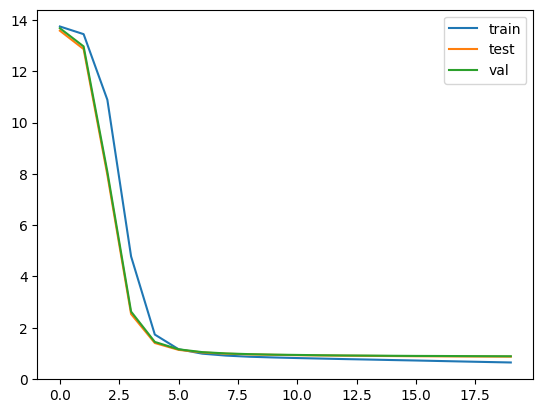

In [21]:
plt.plot(train_loss_master[0:20], label='train')
plt.plot(test_loss_master[0:20], label='test')
plt.plot(val_loss_master[0:20], label='val')
diff = [x - y for x, y in zip(val_loss_master, test_loss_master)]
print(np.mean(diff))
plt.legend()
plt.show()
#around 5-6 epochs --> test loss remains constant --> meaning we start to overfit.

### Question 7: Matrix Factorization (MF) based CF (number of latent factors)

Run the MF model for different number of latent factors $K = \{4, 16, 64, 128\}$. Plot the variation in test MSE error with respect to $K$. What do you observe? 


In [22]:
latent_factors = [4, 16, 64, 128]

test_loss_for_each_k = np.zeros(4)

for i in range(len(latent_factors)):
    test_loss_for_each_k[i] = master_train(user_n_factors = latent_factors[i],  debug_flag = False)[4]

[0.92896928 0.88543558 0.87864554 0.8705483 ]


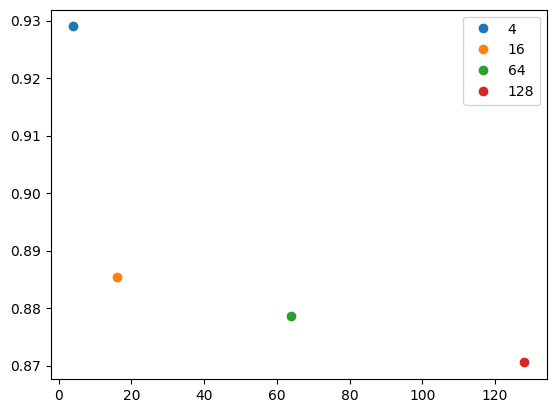

In [23]:
print(test_loss_for_each_k)

for i in range(len(latent_factors)):
    plt.plot(latent_factors[i], test_loss_for_each_k[i], 'o', label = latent_factors[i])

plt.legend()
plt.show()

### Question 8: Matrix Factorization (MF) based CF (batch size)
Model performance depends a lot of batch size and learning rate. What happens when you change the batch size from 2048? Try smaller (16, 64) and larger batch sizes (4096). 

In [24]:
batch_size_candidates = [1024, 128, 16]
learning_rate_candidates = [1e-4, 1e-3, 1e-2]

result = np.zeros((len(batch_size_candidates), len(learning_rate_candidates)))

# for batch_size in batch_size_candidates:
#     for learning_rate in learning_rate_candidates:
#         print("batch_size: ", batch_size, "learning_rate: ", learning_rate)
#         result[batch_size_candidates.index(batch_size)][learning_rate_candidates.index(learning_rate)] = master_train(user_batch_size = batch_size, user_lr = learning_rate, debug_flag = True)[4]


In [25]:
result[0][0] = master_train(user_batch_size = batch_size_candidates[0], user_lr = learning_rate_candidates[0], debug_flag = True)[4]

epoch 0: train loss 13.75053020145582
validation loss:  13.688110138212979
test loss:  13.59074295272978
epoch 1: train loss 13.743683953216111
validation loss:  13.688130633884562
test loss:  13.590775651202765
epoch 2: train loss 13.734814284504324
validation loss:  13.687845128637889
test loss:  13.590517039858302
epoch 3: train loss 13.732651088548744
validation loss:  13.687080481171328
test loss:  13.589793153333048
epoch 4: train loss 13.722540993621385
validation loss:  13.685637590175283
test loss:  13.588340222399678
epoch 5: train loss 13.711376273113748
validation loss:  13.683126034522461
test loss:  13.585830551541358
epoch 6: train loss 13.700962578040967
validation loss:  13.67897306666745
test loss:  13.581634621485927
epoch 7: train loss 13.69266204557557
validation loss:  13.672172149732775
test loss:  13.574748376624422
epoch 8: train loss 13.664341249327729
validation loss:  13.661168677300685
test loss:  13.563584469938393
epoch 9: train loss 13.638096242711164
va

In [26]:
result[0][1] = master_train(user_batch_size = batch_size_candidates[0], user_lr = learning_rate_candidates[1], debug_flag = True)[4]

epoch 0: train loss 13.749117160188979
validation loss:  13.66969058974869
test loss:  13.571499750984529
epoch 1: train loss 13.383037235425865
validation loss:  12.774697658822134
test loss:  12.672400078998749
epoch 2: train loss 10.416131061056387
validation loss:  7.360565890630521
test loss:  7.244220337911372
epoch 3: train loss 4.225011480027351
validation loss:  2.362848287946809
test loss:  2.274969193893156
epoch 4: train loss 1.6200742842494578
validation loss:  1.3936172181636481
test loss:  1.3536388853983548
epoch 5: train loss 1.1367201900136643
validation loss:  1.1416458582289413
test loss:  1.1220262081966237
epoch 6: train loss 0.9850971215013145
validation loss:  1.0445973049730009
test loss:  1.0303658288848763
epoch 7: train loss 0.915104665618012
validation loss:  0.9982497873834161
test loss:  0.9867192434855249
epoch 8: train loss 0.8745047899260037
validation loss:  0.9712211045579523
test loss:  0.9613344033478435
epoch 9: train loss 0.8475786965826283
valid

In [27]:
result[0][2] = master_train(user_batch_size = batch_size_candidates[0], user_lr = learning_rate_candidates[2], debug_flag = True)[4]


epoch 0: train loss 7.568353913832402
validation loss:  1.2116083215115476
test loss:  1.2029769425366177
epoch 1: train loss 0.9419797054235486
validation loss:  1.0039071784052862
test loss:  0.995481336265025
epoch 2: train loss 0.7717393032018689
validation loss:  0.9706830885229828
test loss:  0.9506297500985029
epoch 3: train loss 0.6150991838911305
validation loss:  0.9806392735294316
test loss:  0.9542861078628266
epoch 4: train loss 0.4713483521903771
validation loss:  0.983295473203466
test loss:  0.9632443394289117
epoch 5: train loss 0.36267581582069397
validation loss:  1.0052193374654814
test loss:  0.97934050386109
epoch 6: train loss 0.2935108168833498
validation loss:  1.0100315579703567
test loss:  0.9839777201037846
epoch 7: train loss 0.24516251553659854
validation loss:  1.0208859027503783
test loss:  0.9963908738504621
epoch 8: train loss 0.21721832151862158
validation loss:  1.0249891040341352
test loss:  1.0047401462957897
epoch 9: train loss 0.1962251287439595


In [28]:
result[1][0] = master_train(user_batch_size = batch_size_candidates[1], user_lr = learning_rate_candidates[0], debug_flag = True)[4]


epoch 0: train loss 13.75099651992212
validation loss:  13.701442055115734
test loss:  13.596771473903008
epoch 1: train loss 13.729497902572046
validation loss:  13.69745884884354
test loss:  13.592661215221705
epoch 2: train loss 13.695415875157664
validation loss:  13.678062187882146
test loss:  13.573259236385802
epoch 3: train loss 13.617499606047078
validation loss:  13.59683210465861
test loss:  13.491217099499517
epoch 4: train loss 13.41696278573826
validation loss:  13.320380836643913
test loss:  13.21308070833022
epoch 5: train loss 12.933999180139963
validation loss:  12.654877927402877
test loss:  12.544320487946779
epoch 6: train loss 11.971746831750957
validation loss:  11.441400053017459
test loss:  11.32576014131985
epoch 7: train loss 10.45331219214626
validation loss:  9.710326718009854
test loss:  9.58869632411805
epoch 8: train loss 8.532793873188918
validation loss:  7.723581145976632
test loss:  7.5973465301433585
epoch 9: train loss 6.540738733420643
validation 

In [29]:
result[1][1] = master_train(user_batch_size = batch_size_candidates[1], user_lr = learning_rate_candidates[1], debug_flag = True)[4]


epoch 0: train loss 11.848246182994389
validation loss:  4.816240203064599
test loss:  4.679299124887548
epoch 1: train loss 1.8967600295922873
validation loss:  1.1817908275679931
test loss:  1.1557597009948282
epoch 2: train loss 1.0031201065785271
validation loss:  1.0104704874153785
test loss:  0.994439536183908
epoch 3: train loss 0.895641869012355
validation loss:  0.9578388684655871
test loss:  0.945311119101263
epoch 4: train loss 0.8354209322598124
validation loss:  0.9351328801686233
test loss:  0.9191386620120207
epoch 5: train loss 0.7808133055348719
validation loss:  0.9200619741774049
test loss:  0.9020122320298716
epoch 6: train loss 0.7286822156779726
validation loss:  0.9114078767824284
test loss:  0.8949747046494806
epoch 7: train loss 0.6772495538704574
validation loss:  0.9062708272963936
test loss:  0.8899568729207286
epoch 8: train loss 0.6253521431516685
validation loss:  0.9030313757077368
test loss:  0.8845390649316505
epoch 9: train loss 0.5751197000308272
val

In [30]:
result[1][2] = master_train(user_batch_size = batch_size_candidates[1], user_lr = learning_rate_candidates[2], debug_flag = True)[4]


epoch 0: train loss 3.357623965256393
validation loss:  1.2897567630239808
test loss:  1.2521311207423316
epoch 1: train loss 1.0172733367034243
validation loss:  1.3381813854876243
test loss:  1.2950914172210264
epoch 2: train loss 0.7831372974995503
validation loss:  1.2933345642572085
test loss:  1.2501211981319
epoch 3: train loss 0.6772186273957519
validation loss:  1.289828563737323
test loss:  1.2534226621600213
epoch 4: train loss 0.6319201518892152
validation loss:  1.2749830287500277
test loss:  1.2546868702982261
epoch 5: train loss 0.6183648635199127
validation loss:  1.2889393287818152
test loss:  1.2702416516792265
epoch 6: train loss 0.5983396483622696
validation loss:  1.2608765097398698
test loss:  1.2244158973197743
epoch 7: train loss 0.5904749822028158
validation loss:  1.2252195955320906
test loss:  1.2064836116110051
epoch 8: train loss 0.5735235483925347
validation loss:  1.2279907623322508
test loss:  1.198701823954273
epoch 9: train loss 0.5540176923684708
vali

In [31]:
result[2][0] = master_train(user_batch_size = batch_size_candidates[2], user_lr = learning_rate_candidates[0], debug_flag = True)[4]

epoch 0: train loss nan
validation loss:  13.687265772342506
test loss:  13.581894616821915
epoch 1: train loss nan
validation loss:  12.883329284576375
test loss:  12.774565870050012
epoch 2: train loss nan
validation loss:  9.093011904093656
test loss:  8.970934906687932
epoch 3: train loss nan
validation loss:  4.4292237773861665
test loss:  4.300650482071319
epoch 4: train loss nan
validation loss:  2.4722761592289264
test loss:  2.3815964574840147
epoch 5: train loss nan
validation loss:  1.7477761591762424
test loss:  1.6858532796721113
epoch 6: train loss nan
validation loss:  1.4064755184097844
test loss:  1.3645309913372023
epoch 7: train loss nan
validation loss:  1.2280378786464716
test loss:  1.1978398056527793
epoch 8: train loss nan
validation loss:  1.1299674745689188
test loss:  1.104927929175856
epoch 9: train loss nan
validation loss:  1.0690826218999707
test loss:  1.0492743916145664
epoch 10: train loss nan
validation loss:  1.0322599036538396
test loss:  1.01512235

In [32]:
result[2][1] = master_train(user_batch_size = batch_size_candidates[2], user_lr = learning_rate_candidates[1], debug_flag = True)[4]


epoch 0: train loss nan
validation loss:  1.1456969881345633
test loss:  1.1278570335573028
epoch 1: train loss nan
validation loss:  1.0267588988473042
test loss:  1.0179150521518365
epoch 2: train loss nan
validation loss:  1.0059580453552337
test loss:  0.9798689733628596
epoch 3: train loss nan
validation loss:  0.9792729712994768
test loss:  0.9596363947186103
epoch 4: train loss nan
validation loss:  0.9643032057930752
test loss:  0.968994428697534
epoch 5: train loss nan
validation loss:  0.9775391935094001
test loss:  0.9646237037510956
epoch 6: train loss nan
validation loss:  0.9960619657011115
test loss:  0.9734484660407198
epoch 7: train loss nan
validation loss:  0.9992707976497964
test loss:  0.9896570360100748
epoch 8: train loss nan
validation loss:  1.0048402473492544
test loss:  0.9901732710094144
epoch 9: train loss nan
validation loss:  1.0155132165032288
test loss:  1.0008588505143055
epoch 10: train loss nan
validation loss:  1.0370117857198107
test loss:  1.01414

In [33]:

result[2][2] = master_train(user_batch_size = batch_size_candidates[2], user_lr = learning_rate_candidates[2], debug_flag = True)[4]


epoch 0: train loss nan
validation loss:  2.7723699566595847
test loss:  2.7194298326396042
epoch 1: train loss nan
validation loss:  2.6246074747987413
test loss:  2.5559346829128504
epoch 2: train loss nan
validation loss:  2.448642813203969
test loss:  2.371752101638759
epoch 3: train loss nan
validation loss:  2.284176949400631
test loss:  2.288206911224658
epoch 4: train loss nan
validation loss:  2.2831323251181597
test loss:  2.278019479803031
epoch 5: train loss nan
validation loss:  2.309273668683782
test loss:  2.2548064623402486
epoch 6: train loss nan
validation loss:  2.2547917965341853
test loss:  2.189037170119918
epoch 7: train loss nan
validation loss:  2.195746895963753
test loss:  2.1995599260801595
epoch 8: train loss nan
validation loss:  2.1555064329949767
test loss:  2.1410285554935187
epoch 9: train loss nan
validation loss:  2.184113010682453
test loss:  2.169765316245245
epoch 10: train loss nan
validation loss:  2.11119340004896
test loss:  2.0828794194988163

5. Matrix Factorization with Implicit Feedback (4 credit students or extra-credit) (50 points)

In [38]:
for i in range(len(batch_size_candidates)):
    for j in range(len(learning_rate_candidates)):
        print("batch_size: {}, learning_rate: {}, test MSE: {}".format(batch_size_candidates[i], learning_rate_candidates[j], result[i][j]))



batch_size: 1024, learning_rate: 0.0001, test MSE: 0.9013066346810351
batch_size: 1024, learning_rate: 0.001, test MSE: 0.8721929832350457
batch_size: 1024, learning_rate: 0.01, test MSE: 0.9506297500985029
batch_size: 128, learning_rate: 0.0001, test MSE: 0.8718470807009836
batch_size: 128, learning_rate: 0.001, test MSE: 0.8845390649316505
batch_size: 128, learning_rate: 0.01, test MSE: 1.1008000958531003
batch_size: 16, learning_rate: 0.0001, test MSE: 0.893992713248031
batch_size: 16, learning_rate: 0.001, test MSE: 0.968994428697534
batch_size: 16, learning_rate: 0.01, test MSE: 1.9852973118579096


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MatrixFactorization_Implicit(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, bias=False):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.bias = bias
        
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        if self.bias:
            self.user_bias = torch.nn.Embedding(n_users, 1)
            self.item_bias = torch.nn.Embedding(n_items, 1)
            
            self.user_bias.weight.data.fill_(0.)
            self.user_bias.weight.data.fill_(0.)
        
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
    def forward(self, user, item):
        # matrix multiplication
        if self.bias:
            return self.user_bias(user).squeeze(-1) + self.item_bias(item).squeeze(-1) + \
                (self.user_factors(user)*self.item_factors(item)).sum(-1)
        else:
            return (self.user_factors(user)*self.item_factors(item)).sum(-1)

    def predict(self, user, item):
        return self.forward(user, item)
    

In [36]:
def master_train(user_lr = 1e-3, user_batch_size = 1024, user_n_factors = 128, bias_flag = False, n_epochs = 150, debug_flag = True):
    # hyper-parameters.
    lr = user_lr
    batch_size = user_batch_size
    n_factors = user_n_factors

    model_MF = MatrixFactorization_Implicit(model_CF.n_users, model_CF.n_items, n_factors=n_factors, bias=bias_flag)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model_MF.parameters(), lr=lr, weight_decay=1e-4)

    train_ratings = train[['user_id', 'movie_id', 'rating']].values
    test_ratings = test[['user_id', 'movie_id', 'rating']].values
    val_ratings = val[['user_id', 'movie_id', 'rating']].values

    best_validation_loss_so_far = inf
    best_validation_model = model_MF

    def test_model(model_MF, test_ratings):
        n_batches = len(test_ratings) // batch_size
        preds, targets = [], []
        for b in range(n_batches):
            batch_data = test_ratings[(b* batch_size) : (b+1)* batch_size]        
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            pred = model_MF.predict(user, item).detach()
            pred = np.clip(pred, 0, 5)
            preds.append(pred)
            targets.append(batch_ratings)
        preds, targets = np.concatenate(preds), np.concatenate(targets)
        test_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
        if(debug_flag):
          print ("test loss: ", test_loss)
        return test_loss

    def validate_model(model_MF, val_ratings):
        n_batches = len(val_ratings) // batch_size
        preds, targets = [], []
        for b in range(n_batches):
            batch_data = val_ratings[(b* batch_size) : (b+1)* batch_size]        
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            pred = model_MF.predict(user, item).detach()
            pred = np.clip(pred, 0, 5)
            preds.append(pred)
            targets.append(batch_ratings)
        preds, targets = np.concatenate(preds), np.concatenate(targets)
        val_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
        if(debug_flag):
          print ("validation loss: ", val_loss)
        return val_loss

    train_loss_master = []
    test_loss_master = [] 
    val_loss_master = [] 

    for epoch in range(0, n_epochs):
        train_loss = 0.0
        n_batches = len(train_ratings) // batch_size
        if train_ratings % batch_size is not 0:
            n_batches += 1
        np.random.shuffle(train_ratings)
        for b in range(n_batches):
            batch_data = train_ratings[(b* batch_size) : (b+1)* batch_size]
            # get user, item and rating data
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            rating = torch.FloatTensor(batch_ratings)
            optimizer.zero_grad()
            model_MF.zero_grad()
            
            # predict
            prediction = model_MF(user, item)
            loss = loss_fn(prediction, rating)

            # backpropagate
            loss.backward()

            # update weights
            optimizer.step()
            
            train_loss += loss.item()
        if(debug_flag):
          print ("epoch {}: train loss {}".format(epoch, train_loss/n_batches))

        curr_validation_loss = validate_model(model_MF, val_ratings)
        curr_test_loss = test_model(model_MF, test_ratings)

        if(curr_validation_loss < best_validation_loss_so_far):
          best_validation_model = model_MF
          best_validation_loss_so_far = curr_validation_loss
          best_models_test_loss = curr_test_loss

        train_loss_master.append(train_loss/n_batches)
        test_loss_master.append(curr_test_loss)   
        val_loss_master.append(curr_validation_loss)    

    return train_loss_master, val_loss_master, test_loss_master, best_validation_model, best_models_test_loss

<>:60: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:60: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-36-d0c6e7b73b0c>:60: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if train_ratings % batch_size is not 0:
